# Анализ тональности

### Что такое анализ тональности

**Анализ тональности** (Sentiment Analysis) — задача *определения* эмоциональной окраски текста.

1. Базовая классификация:
    * Positive (позитивная)
    * Negative (негативная)
    * Neutral (нейтральная)

2. Расширенная классификация:

    * Многоклассовая (very positive, positive, neutral, negative, very negative)
    * Эмоции (радость, грусть, злость, удивление и т.д.)
    * Аспектный анализ (тональность к конкретным аспектам продукта)

### Методы решения задачи

* Rule-based подходы — словари с эмоциональной окраской слов
* Machine Learning — классические алгоритмы (что мы будем делать сегодня)
* Deep Learning — нейронные сети и трансформеры

### Метрики качества
Для несбалансированных классов:

* F1-score (гармоническое среднее precision и recall)
* Macro/Micro/Weighted averages
* Confusion matrix для детального анализа ошибок

## Шаг 1. Работа с датасетом

Для начала выполним все нужные импорты

In [ ]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.model_selection import GridSearchCV

import re

import string

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Для примера используем русскоязычный датасет отзывов на товары. Вспомните, где вы его уже видели?
url = "https://raw.githubusercontent.com/sismetanin/rureviews/master/women-clothing-accessories.3-class.balanced.csv"
df = pd.read_csv(url, sep='\t')

print("Размер датасета:", df.shape)

Размер датасета: (90000, 2)


In [ ]:
df.head()

,review,sentiment
0,качество плохое пошив ужасный (горловина напер...,negative
1,"Товар отдали другому человеку, я не получила п...",negative
2,"Ужасная синтетика! Тонкая, ничего общего с пре...",negative
3,"товар не пришел, продавец продлил защиту без м...",negative
4,"Кофточка голая синтетика, носить не возможно.",negative


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90000 entries, 0 to 89999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     90000 non-null  object
 1   sentiment  90000 non-null  object
dtypes: object(2)
memory usage: 1.4+ MB


In [ ]:
df.describe()

,review,sentiment
count,90000,90000
unique,87321,3
top,Товар не пришёл,negative
freq,58,30000


Интересно, уникальный значений в колонке `review` 87321, но всего значений 90000.

> Что это значит для нас? Нужно ли нам предпринять какие-то меры?



### Дубликаты

In [ ]:
df.duplicated() # вывод какой-то не очень красивый. Что если добавить .sum()?

,0
0,False
1,False
2,False
3,False
4,False
...,...
89995,False
89996,False
89997,False
89998,False


In [ ]:
print(f"Процент дубликатов: {df.duplicated().sum() / len(df) * 100:.2f}%")

Процент дубликатов: 2.50%


Это значит, что у нас 2250 полностью дублирующих друг друга строк! Но это все равно не объясняет количество уникальный текстов, т.е. `90,000 - 2,250 = 87,750`. У вас должны возникнуть вопросы

In [ ]:
df['review'].duplicated().sum()

np.int64(2679)

Здесь мы как раз подтвердили, что...

> Что мы подтвердили?

Избавимся от полностью дублирующихся строк и посмотрим, что станет с дублирующимися текстам отзывов.

In [ ]:
df = df.drop_duplicates()

df.shape

(87750, 2)

In [ ]:
df['review'].duplicated().sum()

np.int64(429)

А они остались! Посмотрим, что они из себя представляют.

In [ ]:
duplicated_reviews = df[df['review'].duplicated(keep=False)].sort_values('review')
duplicated_reviews.head(10)

,review,sentiment
30580,!,neautral
86378,!,positive
46354,!!!,neautral
8511,!!!,negative
44304,-,neautral
11855,-,negative
3959,.,negative
30822,.,neautral
75390,.,positive
36934,..,neautral


Очень информативно... Интересно, что в разных случая точка может восприниматься нейтрально, а в других - положительно)

**Что делать?**

Мы оставим только первое вхождение, а остальные удалим. Хорошо, что это уже заложено в метод `.drop_duplictes()`

In [ ]:
df = df.drop_duplicates(subset=['review'])
df.shape

(87321, 2)

In [ ]:
# Проверим еще раз!

df['review'].duplicated().sum()

np.int64(0)

Отлично! Теперь у нас нет дубликатов текстов

### Длина текстов

In [ ]:
df['text_length'] = df['review'].str.len()
df['word_count'] = df['review'].str.split().str.len()

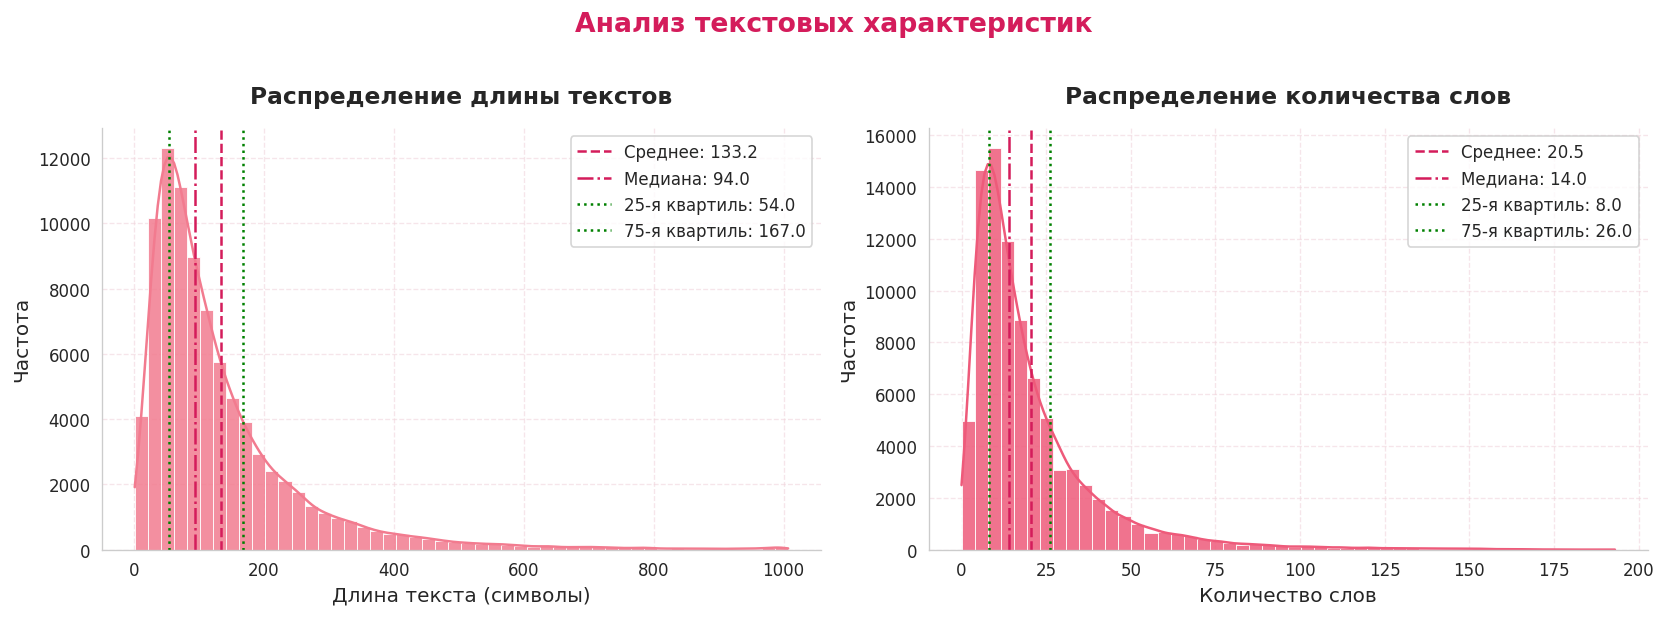

In [ ]:
sns.set_style("whitegrid")
pink_palette = ["#f8a9b3", "#f27b8f", "#ee5a7a", "#e73a63", "#d41c5b"]
sns.set_palette(sns.color_palette(pink_palette))

fig, axes = plt.subplots(1, 2, figsize=(14, 5), dpi=120)

# Plot 1: Text Length
sns.histplot(df['text_length'], bins=50, kde=True, ax=axes[0],
             color="#f27b8f", edgecolor='white', linewidth=0.5, alpha=0.85)
axes[0].axvline(df['text_length'].mean(), color='#d41c5b', linestyle='--', label=f"Среднее: {df['text_length'].mean():.1f}")
axes[0].axvline(df['text_length'].median(), color='#d41c5b', linestyle='-.', label=f"Медиана: {df['text_length'].median():.1f}")
axes[0].axvline(np.percentile(df['text_length'], 25), color='green', linestyle=':', label=f"25-я квартиль: {np.percentile(df['text_length'], 25):.1f}")
axes[0].axvline(np.percentile(df['text_length'], 75), color='green', linestyle=':', label=f"75-я квартиль: {np.percentile(df['text_length'], 75):.1f}")
axes[0].legend()
axes[0].set_xlabel('Длина текста (символы)', fontsize=12, fontweight='medium')
axes[0].set_ylabel('Частота', fontsize=12, fontweight='medium')
axes[0].set_title('Распределение длины текстов', fontsize=14, fontweight='bold', pad=15)
axes[0].grid(True, linestyle='--', alpha=0.6, color='#f0d5dc')
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)

# Plot 2: Word Count
sns.histplot(df['word_count'], bins=50, kde=True, ax=axes[1],
             color="#ee5a7a", edgecolor='white', linewidth=0.5, alpha=0.85)
axes[1].axvline(df['word_count'].mean(), color='#d41c5b', linestyle='--', label=f"Среднее: {df['word_count'].mean():.1f}")
axes[1].axvline(df['word_count'].median(), color='#d41c5b', linestyle='-.', label=f"Медиана: {df['word_count'].median():.1f}")
axes[1].axvline(np.percentile(df['word_count'], 25), color='green', linestyle=':', label=f"25-я квартиль: {np.percentile(df['word_count'], 25):.1f}")
axes[1].axvline(np.percentile(df['word_count'], 75), color='green', linestyle=':', label=f"75-я квартиль: {np.percentile(df['word_count'], 75):.1f}")
axes[1].legend()
axes[1].set_xlabel('Количество слов', fontsize=12, fontweight='medium')
axes[1].set_ylabel('Частота', fontsize=12, fontweight='medium')
axes[1].set_title('Распределение количества слов', fontsize=14, fontweight='bold', pad=15)
axes[1].grid(True, linestyle='--', alpha=0.6, color='#f0d5dc')
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)

plt.suptitle('Анализ текстовых характеристик', fontsize=16, fontweight='bold', color='#d41c5b', y=1.02)
plt.tight_layout()
plt.show()

Мы видим, что у нас много выбросов

In [ ]:
# Примеры очень коротких текстов:

df[df['word_count'] < 3][['review', 'sentiment']].head(10)

,review,sentiment
71,Велико,negative
91,Качество отвратительное,negative
130,Не пришло.,negative
189,материал отвратительный,negative
358,Очень короткая,negative
472,Пошито отвратительно,negative
532,Качество стремное.,negative
588,огромный,negative
607,Товар дырявый,negative
658,Тряпка,negative


In [ ]:
# Примеры очень длинных текстов:

df[df['word_count'] > 150][['review', 'sentiment']].head(10)

,review,sentiment
749,Всем привет ! Наконец то нашла время написать ...,negative
763,уфф..одно хочу сказать ОБЯЗАТЕЛЬНО общайтесь с...,negative
920,"Ну вот и закончилась, наконец, эпопея с этим з...",negative
1094,"мое разочарование.Продавец, конечно, милашка -...",negative
1961,"Здравствуйте, заказ шёл 24 дня. достаточно бы...",negative
2660,"Заказа платье в день распродаж 11.11.2017., но...",negative
2817,Качество шубы просто отвратительное. Вся шуба ...,negative
3112,Отвратительно! Первую посылку вернули продавцу...,negative
3124,15 дней с момента заказа (5 обработка + 10 дос...,negative
3242,"не знаю на кого это платье, видимо на женщин у...",negative


Слишком много одинаковых начал текстов может указывать на шаблонные данные. К примеру, боты конкурентов нагенерировали плохих отзывов. Посмотрим, что там творится

In [ ]:
first_words = df['review'].str.split().str[:3].str.join(' ')
print("Наиболее частые начала текстов:")
first_words.value_counts().head(10)

Наиболее частые начала текстов:


,count
review,
Товар так и,333
"Товар не пришёл,",268
товар так и,222
Товар не пришёл,193
Заказ так и,179
"товар не пришел,",175
Товар не пришёл.,168
"Товар не пришел,",135
Размер не соответствует,132


В анализе данных есть популярная практика: удалять выбросы по длине текстов, оставляя только значения между 25-м и 75-м перцентилями (интерквартильный размах). Проверим, поможет ли это нашему датасету!

In [ ]:
df_filtered = df[(df['word_count'] >= 8) & (df['word_count'] <= 26)]

print(f"Размер датасета после фильтрации: {len(df_filtered)}")
print(f"Удалено строк: {len(df) - len(df_filtered)} ({(len(df) - len(df_filtered))/len(df)*100:.1f}%)")

Размер датасета после фильтрации: 46786
Удалено строк: 40535 (46.4%)


### Анализ распределения классов

In [ ]:
class_distribution = df_filtered['sentiment'].value_counts().sort_index()
print("Распределение классов:")
print(class_distribution)
print(f"\nБаланс классов:")
print(class_distribution / len(df_filtered) * 100)

Распределение классов:
sentiment
neautral    14714
negative    16452
positive    15620
Name: count, dtype: int64

Баланс классов:
sentiment
neautral    31.449579
negative    35.164365
positive    33.386056
Name: count, dtype: float64


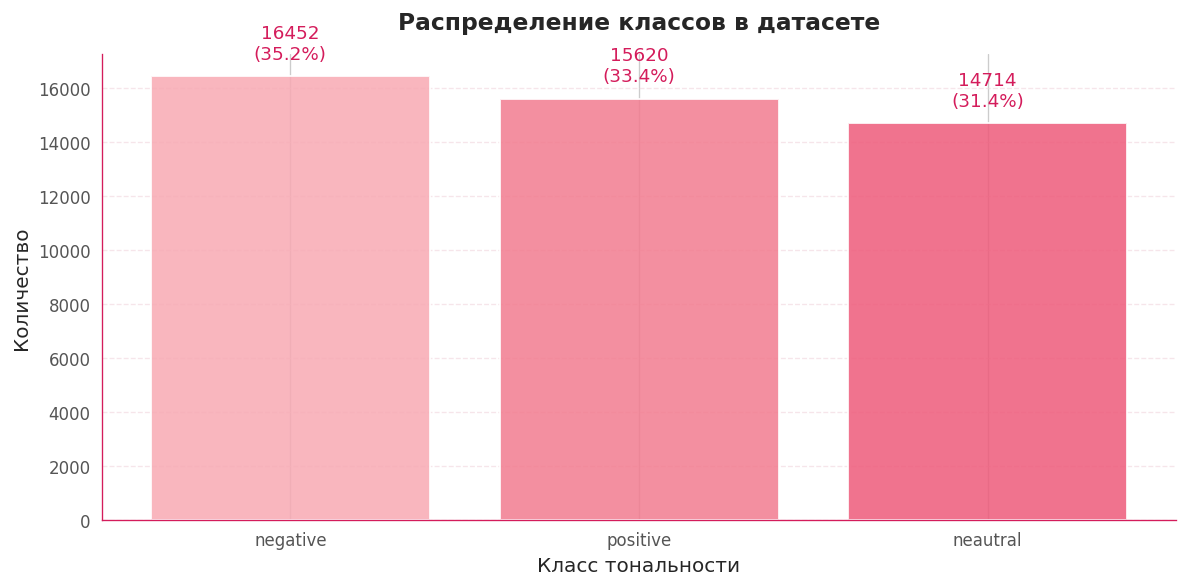

In [ ]:
counts = df_filtered['sentiment'].value_counts()
x_labels = counts.index
values = counts.values

# Plot setup
plt.figure(figsize=(10, 5), dpi=120)
bars = plt.bar(x_labels, values, color=pink_palette, edgecolor='white', linewidth=1.2, alpha=0.85)

# Add annotations
total = len(df_filtered)
for i, (bar, count) in enumerate(zip(bars, values)):
    height = bar.get_height()
    plt.annotate(f'{int(count)}\n({count/total*100:.1f}%)',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 8),
                 textcoords="offset points",
                 ha='center', va='bottom',
                 fontsize=11, fontweight='medium',
                 color='#d41c5b')

# Styling
plt.xlabel('Класс тональности', fontsize=12, fontweight='medium')
plt.ylabel('Количество', fontsize=12, fontweight='medium')
plt.title('Распределение классов в датасете', fontsize=14, fontweight='bold', pad=15)

# Grid & spines
plt.grid(True, axis='y', linestyle='--', alpha=0.6, color='#f0d5dc')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#d41c5b')
ax.spines['bottom'].set_color('#d41c5b')
ax.tick_params(colors='#555')

plt.tight_layout()
plt.show()

**Дисбаланс классов** — это ситуация, когда в обучающем датасете количество примеров одного класса значительно превосходит количество примеров другого класса. Например:
- 95% примеров — "Негативные" отзывы, 5% — "Позитивные"
- 99% транзакций — нормальные, 1% — мошеннические
- 90% пациентов — здоровые, 10% — больные

**Почему это проблема?**

1. Модель становится "ленивой"

    Когда один класс доминирует, модели выгоднее всегда предсказывать этот класс. Например:
    - Если 95% отзывов негативные, модель может достичь 95% точности (accuracy), просто всегда предсказывая "Негативный"
    - Но такая модель бесполезна на практике!

> *Кстати, какая точность будет у модели, если она предскажет все negative в таком случае?*

2. Метрики вводят в заблуждение
    - **Accuracy (точность)** становится бесполезной метрикой
    - Модель может показывать 99% accuracy на несбалансированном датасете, но при этом вообще не находить редкие классы

3. Алгоритмы машинного обучения смещены
    Большинство алгоритмов (логистическая регрессия, деревья решений, нейросети) оптимизируют общую ошибку. Им "выгоднее" ошибаться на редких классах, чем на частых.

**Обнаружив дисбаланс заранее, мы можем применить методы балансировки:**

Методы до обучения (data-level):
- **Андерсэмплинг (undersampling)** — уменьшение большинства класса
- **Оверсэмплинг (oversampling)** — увеличение меньшинства класса
- **SMOTE** — синтез новых примеров для редкого класса
- **Взвешивание классов (class weights)** — назначение больших весов редким классам

Методы во время обучения (algorithm-level):
- **Изменение порога классификации**
- **Ансамбли моделей** (bagging, boosting с фокусом на ошибках)
- **Специализированные алгоритмы** для несбалансированных данных

Проведем анализ дисбаланса классов и решим, что с этим всем делать

In [ ]:
class_distribution = df_filtered['sentiment'].value_counts()
min_class = class_distribution.min()
max_class = class_distribution.max()
imbalance_ratio = max_class / min_class if min_class > 0 else float('inf')

print(f"{'='*50}")
print(f"Анализ дисбаланса классов:")
print(f"{'='*50}")
for class_name, count in class_distribution.items():
    percentage = count / len(df_filtered) * 100
    print(f"{class_name}: {count} примеров ({percentage:.1f}%)")

print(f"\nКоэффициент дисбаланса: {imbalance_ratio:.2f}")

if imbalance_ratio > 10:
    print("КРИТИЧЕСКИЙ ДИСБАЛАНС! Требуются методы балансировки")
elif imbalance_ratio > 2:
    print("УМЕРЕННЫЙ ДИСБАЛАНС. Рекомендуется методы балансировки")
else:
    print("✓ Датасет достаточно сбалансирован. Обучение можно проводить стандартно.")

Анализ дисбаланса классов:
negative: 16452 примеров (35.2%)
positive: 15620 примеров (33.4%)
neautral: 14714 примеров (31.4%)

Коэффициент дисбаланса: 1.12
✓ Датасет достаточно сбалансирован. Обучение можно проводить стандартно.


#### **Imbalance Ratio: Метрика дисбаланса классов**

**Imbalance Ratio** — это числовая метрика, которая количественно оценивает степень дисбаланса между классами в датасете. Проще говоря, она показывает **во сколько раз один класс превосходит другой** по количеству примеров.

```python
# Для бинарной классификации
imbalance_ratio = count_majority_class / count_minority_class

# Для мультиклассовой классификации
imbalance_ratio = max(class_counts) / min(class_counts)
```

#### **Как интерпретировать imbalance ratio?**

- **1.0 - 1.5**: **Идеальный баланс**
  - Модель обучается стабильно
  - Стандартные метрики работают корректно
  
- **1.5 - 5.0**: **Легкий дисбаланс**
  - Требует внимания при выборе метрик
  - Может потребоваться небольшая корректировка весов
  
- **5.0 - 20.0**: **Умеренный дисбаланс**
  - Стандартная accuracy становится ненадежной
  - **Рекомендуется применение методов балансировки**
  
- **20.0+**: **Критический дисбаланс**
  - Модель будет игнорировать редкий класс
  - **Требуются активные методы балансировки**


#### Почему imbalance ratio важнее простого процентного соотношения?

1. **Универсальность**
   - Работает для любого количества классов
   - Позволяет сравнивать дисбаланс между разными датасетами

2. **Чувствительность к экстремальным случаям**
   - 99% vs 1% → ratio = 99
   - 99.9% vs 0.1% → ratio = 999
   - Разница в 10 раз видна сразу!

3. **Практическая применимость**
   - Позволяет автоматизировать выбор стратегии балансировки
   - Интегрируется в пайплайны предобработки данных


#### Важно!

- **Не учитывает стоимость ошибок**
  - В медицине ошибка на редком классе дороже, чем в рекомендациях
  - Нужно комбинировать с бизнес-метриками

- **Не показывает распределение в мультиклассовых задачах**
  - Для 3+ классов лучше смотреть на полное распределение
  - Используйте визуализацию (bar plots, pie charts)

- **Может ввести в заблуждение при очень маленьких датасетах**
  - 10 примеров vs 1 пример → ratio = 10, но это статистически незначимо
  - Всегда проверяйте абсолютные числа!


*Помните: даже при imbalance ratio = 3.0 модель может сильно смещаться в сторону majority класса, если использовать неправильные метрики.*

> Стоило ли обрезать датасет? Что мы потеряли, что приобрели?

### Анализ текстовых характеристик по классам

Для экономии времени на семинаре мы не будем строить вновь графики и посмотрим только на баланс по количеству слов, но помните, что графики здесь тоже можно и нужно применять!

In [ ]:
print("Среднее количество слов по классам:")
print(df_filtered.groupby('sentiment')['word_count'].mean())

Среднее количество слов по классам:
sentiment
neautral    14.968126
negative    14.887734
positive    14.990653
Name: word_count, dtype: float64


Итак, мы проанализировали датасет и даже отфильтровали по длине.

> Подходит ли этот датасет для обучения модели? Почему?

## Шаг 2. Предобработка и подготовка данных

Мы делали это уже 1000 раз, так что просто почистим все молча и пойдем дальше)

In [ ]:
def clean_text(text):
    # Приведение к нижнему регистру
    text = text.lower()

    # Удаление URL
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Оставим только кириллицу. Помните, что было, если оставить и латиницу?
    text = re.sub(r'[^а-яА-ЯёЁ\s]', '', text)

    # Удаление HTML тегов
    text = re.sub(r'<.*?>', '', text)

    # Удалим числа, чтобы посмотреть именно на слова
    text = re.sub(r'\d+', '', text)

    # Удаление лишних пробелов
    text = re.sub(r'\s+', ' ', text).strip()

    return text

df_filtered['review_clean'] = df_filtered['review'].apply(clean_text)

Разделяем наши данные на обучающую и тестовую выборки

In [ ]:
X = df_filtered['review_clean']
y = df_filtered['sentiment']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # сохраняем пропорции классов
)

print(f"Размер обучающей выборки: {len(X_train)}")
print(f"Размер тестовой выборки: {len(X_test)}")
print(f"\nРаспределение классов в train:")
print(y_train.value_counts(normalize=True))
print(f"\nРаспределение классов в test:")
print(y_test.value_counts(normalize=True))

Размер обучающей выборки: 37428
Размер тестовой выборки: 9358

Распределение классов в train:
sentiment
negative    0.351635
positive    0.333868
neautral    0.314497
Name: proportion, dtype: float64

Распределение классов в test:
sentiment
negative    0.351678
positive    0.333832
neautral    0.314490
Name: proportion, dtype: float64


Векторизируем!



In [ ]:
vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),  # униграммы и биграммы
    min_df=2,  # слово должно встречаться минимум в 2 документах
    max_df=0.8  # слово не должно встречаться более чем в 80% документов
)

X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

print(f"Размерность векторов: {X_train_vec.shape[1]}")
print(f"Примеры признаков (слов):")
print(vectorizer.get_feature_names_out()[:20])

Размерность векторов: 5000
Примеры признаков (слов):
['абсолютно' 'абсолютно не' 'августа' 'адрес' 'адрес деньги' 'адресу' 'аж'
 'айс' 'аккуратная' 'аккуратно' 'аккуратные' 'али' 'али вернул'
 'али экспресс' 'алиэкспресс' 'алиэкспресс вернул' 'алиэкспресс вернули'
 'алиэкспресс деньги' 'апреле' 'ателье']


## Шаг 3. Обучение моделей

Начнем с обучения нескольких классических алгоритмов машинного обучения с базовыми параметрами, чтобы понять, как они справляются с задачей анализа тональности.

### 1. Logistic Regression (Логистическая регрессия)

**Логистическая регрессия** — линейный классификатор, который предсказывает вероятность принадлежности к классу через логистическую (сигмоидную) функцию. Модель находит оптимальные веса для признаков, которые минимизируют ошибку классификации.

Представьте, что вы сортируете письма: модель смотрит на ключевые слова и говорит: "с 85% вероятностью это позитивный отзыв".

**Как работает (простыми словами):**  
Модель изучает, какие слова чаще встречаются в позитивных, негативных и нейтральных отзывах. Затем для нового текста она складывает "вес" каждого слова и выдает вероятность для каждого класса.

**Когда использовать:**
* Быстрое обучение на больших данных
* Интерпретируемость важна (можно посмотреть веса признаков)
* Линейно разделимые классы

**Преимущества:**
* Быстрое обучение и предсказание
* Показывает вероятности ("на 70% это positive review")
* Хорошо работает с TF-IDF векторами


In [ ]:
lr_model = LogisticRegression(
    random_state=42,
    max_iter=1000
)

lr_model.fit(X_train_vec, y_train)
y_pred_lr = lr_model.predict(X_test_vec)

In [ ]:
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

    neautral       0.59      0.62      0.61      2943
    negative       0.74      0.71      0.73      3291
    positive       0.86      0.85      0.85      3124

    accuracy                           0.73      9358
   macro avg       0.73      0.73      0.73      9358
weighted avg       0.73      0.73      0.73      9358



In [ ]:
lr_f1 = f1_score(y_test, y_pred_lr, average='weighted')
print(f"F1-score (weighted): {lr_f1:.4f}\n")

F1-score (weighted): 0.7310




#### Как читать classification report?

**Precision (Точность)** — доля правильно предсказанных положительных примеров среди всех примеров, которые модель отнесла к этому классу.
- Формула: `TP / (TP + FP)`
- Пример: Для класса `positive` precision = 0.86 означает, что 86% примеров, которые модель назвала положительными, действительно являются положительными.

**Recall (Полнота)** — доля правильно предсказанных положительных примеров среди всех реальных положительных примеров в данных.
- Формула: `TP / (TP + FN)`
- Пример: Для класса `negative` recall = 0.71 означает, что модель нашла 71% всех реальных негативных отзывов.

**F1-score** — гармоническое среднее между precision и recall. Полезно, когда нужно учесть оба показателя одновременно.
- Формула: `2 * (precision * recall) / (precision + recall)`
- Пример: Для класса `neautral` F1-score = 0.61 показывает сбалансированную производительность.

**Support** — количество реальных примеров каждого класса в тестовых данных.
- Пример: Класс `negative` имеет 3291 пример, что помогает понять, насколько метрики надежны для этого класса.



**Accuracy (Общая точность)** — доля всех правильно предсказанных примеров.
- Пример: Accuracy = 0.73 означает, что модель правильно предсказала 73% всех примеров.

**Macro avg** — среднее арифметическое метрик по всем классам без учета их размера.
- Полезно, когда все классы одинаково важны, независимо от их количества.

**Weighted avg** — среднее, взвешенное по количеству примеров в каждом классе.
- Учитывает дисбаланс классов и показывает общую производительность с учетом размера каждого класса.



**Как это анализировать и применять в описании анализа?**

1. **Проверьте дисбаланс классов** через колонку `support` — у нас примерно равное количество примеров для каждого класса (2943, 3291, 3124).

2. **Оцените производительность по каждому классу**:
   - Лучше всего модель работает с классом `positive` (F1=0.85)
   - Хуже всего — с классом `neautral` (F1=0.61)

3. **Сравните macro avg и weighted avg** — в нашем случае они совпадают (0.73), что говорит о сбалансированности классов.

4. **Обратите внимание на проблемные классы** — низкий F1-score для `neautral` указывает, что модель испытывает трудности с нейтральными отзывами.

Такой анализ помогает понять не только общую точность модели, но и выявить конкретные слабые места для дальнейшего улучшения.

### 2. Naive Bayes (Наивный байесовский классификатор)

Naive Bayes основан на теореме Байеса и предположении о независимости признаков. MultinomialNB особенно хорош для текстовых данных, так как работает с частотами слов.

Naive Bayes — как "наивный эксперт", который верит, что каждое слово влияет на результат независимо от других. Это классический метод для текстовой классификации, похожий на спам-фильтр в вашей почте.

**Как работает (простыми словами):**  
Модель запоминает: "слово 'отлично' в 80% случаев встречается в позитивных отзывах, а 'ужасно' — в 95% в негативных". Для нового текста она просто считает, каких "подсказывающих" слов больше.

**Когда использовать:**
- Очень быстрое обучение и предсказание
- Хорошо работает на небольших данных
- Классический выбор для текстовой классификации

**Особенности:**
- Очень простой и быстрый (идеален для старта)
- Не пугается, если в данных один класс встречается чаще других
- Требует меньше примеров для обучения, чем другие модели
- "Наивность" — его особенность, а не недостаток: работает удивительно хорошо для текста!



In [ ]:
nb_model = MultinomialNB()

nb_model.fit(X_train_vec, y_train)
y_pred_nb = nb_model.predict(X_test_vec)

In [ ]:
print(classification_report(y_test, y_pred_nb))

              precision    recall  f1-score   support

    neautral       0.57      0.68      0.62      2943
    negative       0.75      0.65      0.70      3291
    positive       0.86      0.83      0.84      3124

    accuracy                           0.72      9358
   macro avg       0.73      0.72      0.72      9358
weighted avg       0.73      0.72      0.72      9358



In [ ]:
nb_f1 = f1_score(y_test, y_pred_nb, average='weighted')
print(f"F1-score (weighted): {nb_f1:.4f}\n")

F1-score (weighted): 0.7217



### 3. Support Vector Machine (Метод опорных векторов)

**SVM** ищет оптимальную гиперплоскость, которая максимально разделяет классы.

SVM — как бы рисует идеальную границу между разными классами. Он ищет такую линию раздела, чтобы между классами оставалось максимальное "буферное пространство".

**LinearSVC** — линейная версия, эффективная для высокоразмерных данных (как текст).

Основная идея: он находит границу решения, которая максимизирует расстояние до ближайших точек каждого класса (опорных векторов).

**Как работает (простыми словами):**  
Представьте два города на карте. SVM найдет такую дорогу между ними, чтобы расстояние от дороги до ближайших домов каждого города было максимально большим. Для текста это значит, что модель найдет самые надежные слова-разделители.

**Когда использовать:**

* Высокоразмерные данные (текст, изображения)
* Нужна высокая точность
* Классы хорошо разделимы

**Особенности:**

* Очень точный, особенно для текстовых данных
* Экономит память: запоминает только самые важные примеры ("граничные случаи")
* Чувствителен к масштабу данных (требует предварительной подготовки)
* Может работать дольше других моделей на больших наборах данных

In [ ]:
svm_model = LinearSVC(
    random_state=42,
    max_iter=2000
)

svm_model.fit(X_train_vec, y_train)
y_pred_svm = svm_model.predict(X_test_vec)

In [ ]:
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

    neautral       0.58      0.59      0.59      2943
    negative       0.72      0.71      0.72      3291
    positive       0.85      0.85      0.85      3124

    accuracy                           0.72      9358
   macro avg       0.72      0.72      0.72      9358
weighted avg       0.72      0.72      0.72      9358



In [ ]:
svm_f1 = f1_score(y_test, y_pred_svm, average='weighted')
print(f"F1-score (weighted): {svm_f1:.4f}\n")

F1-score (weighted): 0.7198



### 4. Random Forest (Случайный лес)

**Random Forest** — ансамбль деревьев решений. Каждое дерево обучается на случайной подвыборке данных и признаков, затем результаты усредняются (голосование).

"Мудрость толпы" — множество слабых моделей вместе дают сильную модель.

**Как работает (простыми словами):**  
Представьте 100 экспертов, которые анализируют один и тот же отзыв, но каждый смотрит на разные аспекты. Один эксперт обращает внимание на эмоциональные слова, другой — на оценки, третий — на упоминания продуктов. Итоговое решение принимается голосованием: если 70 экспертов сказали "позитив", значит это позитив.

**Когда использовать:**

* Нужна устойчивость к переобучению
* Важна интерпретируемость (feature importance)
* Нелинейные зависимости в данных

**Особенности:**

* Устойчив к выбросам и шуму
* Не требует тщательной подготовки данных (не нужно масштабировать признаки)
* Может быть медленным на больших данных

In [ ]:
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_vec, y_train)
y_pred_rf = rf_model.predict(X_test_vec)

In [ ]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

    neautral       0.59      0.58      0.59      2943
    negative       0.73      0.71      0.72      3291
    positive       0.80      0.84      0.82      3124

    accuracy                           0.71      9358
   macro avg       0.71      0.71      0.71      9358
weighted avg       0.71      0.71      0.71      9358



In [ ]:
rf_f1 = f1_score(y_test, y_pred_rf, average='weighted')
print(f"F1-score (weighted): {rf_f1:.4f}\n")

F1-score (weighted): 0.7122



### Визуализация моделей

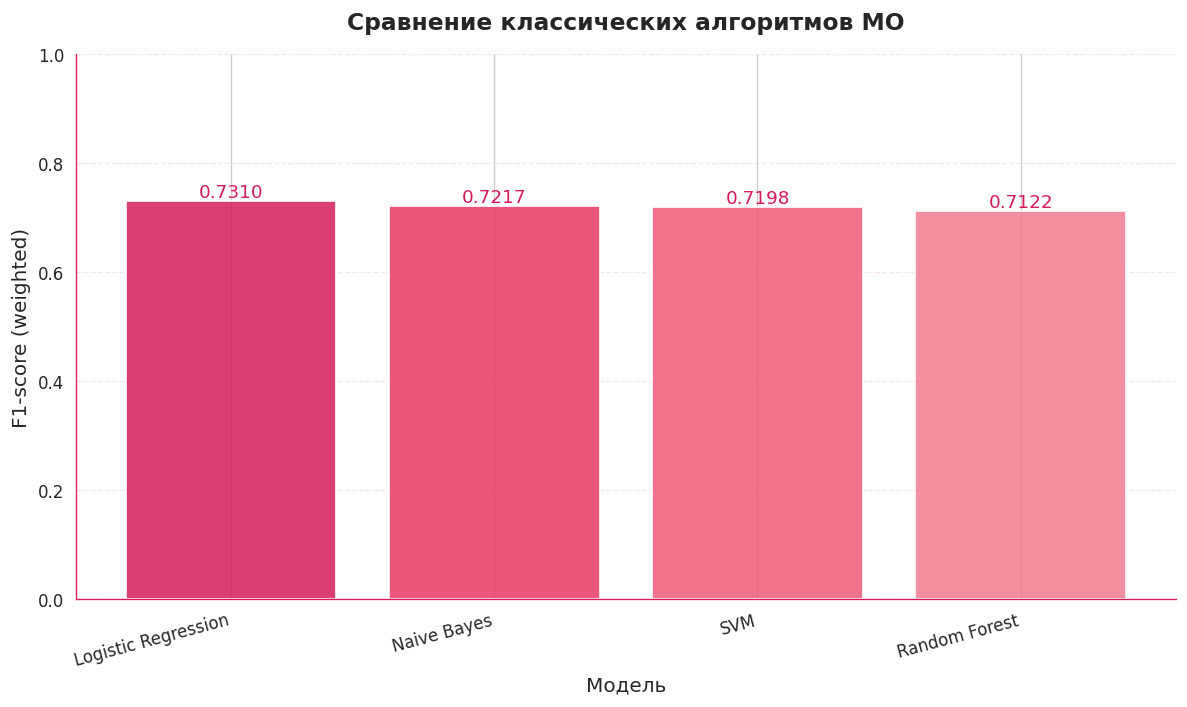

In [ ]:
models_results = {
    'Logistic Regression': lr_f1,
    'Naive Bayes': nb_f1,
    'SVM': svm_f1,
    'Random Forest': rf_f1
}

plt.figure(figsize=(10, 6), dpi=120)
bars = plt.bar(models_results.keys(), models_results.values(),
               color=pink_palette[4::-1], edgecolor='white', linewidth=1.2, alpha=0.85)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}',
             ha='center', va='bottom',
             fontsize=11, fontweight='medium', color='#d41c5b')

plt.xlabel('Модель', fontsize=12, fontweight='medium')
plt.ylabel('F1-score (weighted)', fontsize=12, fontweight='medium')
plt.title('Сравнение классических алгоритмов МО', fontsize=14, fontweight='bold', pad=15)
plt.ylim(0, 1.0)
plt.grid(True, axis='y', linestyle='--', alpha=0.6, color='#f0d5dc')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#d41c5b')
ax.spines['bottom'].set_color('#d41c5b')

plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.show()

### Confusion matrix

Лучшая модель: Logistic Regression с F1-score: 0.7310


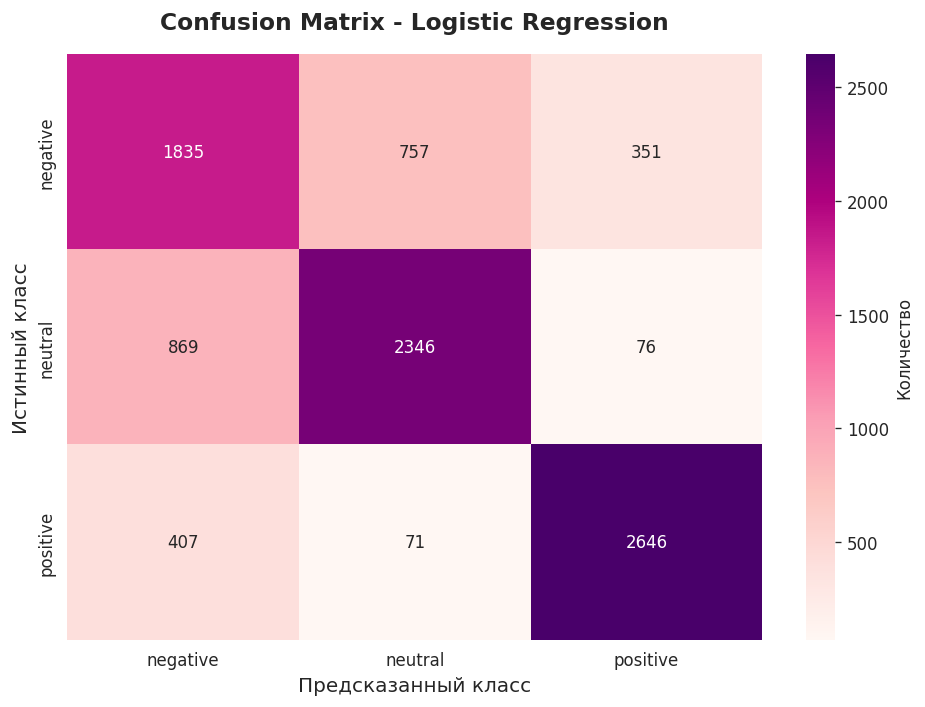

In [ ]:
# Выбираем модель с лучшим F1-score
best_model_name = max(models_results, key=models_results.get)
print(f"Лучшая модель: {best_model_name} с F1-score: {models_results[best_model_name]:.4f}")

# Получаем предсказания лучшей модели
if best_model_name == 'Logistic Regression':
    y_pred_best = y_pred_lr
elif best_model_name == 'Naive Bayes':
    y_pred_best = y_pred_nb
elif best_model_name == 'SVM':
    y_pred_best = y_pred_svm
else:
    y_pred_best = y_pred_rf

# Строим confusion matrix
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(8, 6), dpi=120)
sns.heatmap(cm, annot=True, fmt='d', cmap='RdPu',
            xticklabels=['negative', 'neutral', 'positive'],
            yticklabels=['negative', 'neutral', 'positive'],
            cbar_kws={'label': 'Количество'})

plt.xlabel('Предсказанный класс', fontsize=12, fontweight='medium')
plt.ylabel('Истинный класс', fontsize=12, fontweight='medium')
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold', pad=15)
plt.tight_layout()
plt.show()

#### Зачем смотреть Confusion Matrix (Матрицу ошибок)?

**Общая точность (accuracy) не расскажет всю правду.**  
Матрица ошибок показывает **где именно модель ошибается**, что критически важно для улучшения модели и понимания её слабых мест.

---

1. **Сильные стороны модели**  
   - Лучше всего справляется с **позитивными** отзывами (2646 верных предсказаний)  
   - Хорошо распознает **нейтральные** (2346 верных), но с оговоркой...

2. **Проблемные места**  
   - **Нейтральные отзывы часто путает с негативными** (869 ошибок)
   - **Негативные иногда ошибочно считает позитивными** (351 ошибка)  
     → *Пример:* Саркастические фразы ("О, конечно, просто супер!") модель не распознает

3. **Дисбаланс в ошибках**  
   - Ошибки в сторону **нейтральных** минимальны (76 для позитивных, 71 для негативных)  
   - Зато **нейтральные → негативные** — самая частая ошибка (869)

---

**Почему это важно?**

- Если ваша задача — выявлять негативные отзывы для срочного реагирования, эта матрица показывает, что **модель пропустит 351 негативный отзыв**, приняв его за позитивный (сарказм!).  
- Для улучшения можно:  
    * Добавить данные с саркастическими отзывами  
    * Усилить вес слов, характерных для нейтральных текстов (типа "нормально", "так себе")  
    * Проверить, не перепутаны ли метки в исходных данных для нейтральных текстов

### Подбор гиперпараметров

**GridSearchCV** — метод перебора комбинаций гиперпараметров для поиска оптимальной конфигурации модели. Он автоматически обучает модель на всех возможных комбинациях параметров и выбирает лучшую по заданной метрике.

**Как это работает:**
1. Задаем сетку параметров (grid)
2. GridSearchCV перебирает все комбинации
3. Для каждой комбинации проводится кросс-валидация
4. Выбирается комбинация с лучшим результатом

**Преимущества:**
- Автоматизация подбора параметров
- Кросс-валидация на обучающей выборке
- Гарантия нахождения лучшей комбинации из заданных

**Недостатки:**
- Вычислительно затратный процесс
- Ограничен заданной сеткой параметров

Для демонстрации возьмем логистическую регрессию и подберем для нее оптимальные параметры.

Обычно GridSearch выглядит так, но что-то я разошлась...

```python
# Определяем сетку параметров
param_grid = {
    'C': [0.1, 1, 10],  # регуляризация
    'max_iter': [100, 200]
}

# Создаем объект GridSearchCV
grid_search = GridSearchCV(
    LogisticRegression(random_state=42),
    param_grid,
    cv=3,  # 3-fold cross-validation
    scoring='f1_weighted',  # метрика для несбалансированных классов
    n_jobs=-1,  # используем все ядра процессора
    verbose=1
)

print("Подбор гиперпараметров для Logistic Regression...")
grid_search.fit(X_train_vec, y_train)

print(f"\nЛучшие параметры: {grid_search.best_params_}")
print(f"Лучший F1-score (weighted) на кросс-валидации: {grid_search.best_score_:.4f}")

best_lr = grid_search.best_estimator_
```

#### Как подбираем параметры на практике:

**1. Параметр `C` (сила регуляризации):**
- **Маленькое значение (0.01-0.1):** Модель становится "осторожной", меньше переобучается, но может недоучиться
- **Среднее значение (1.0):** Баланс между обучением и обобщением
- **Большое значение (10-100):** Модель пытается идеально подстроиться под данные, риск переобучения
- **Как выбирать:** Начинаем с логарифмической шкалы `[0.01, 0.1, 1, 10, 100]`

**2. Параметр `max_iter` (максимальное количество итераций):**
- Для текстовых данных часто нужно много итераций для сходимости
- **Слишком мало (100):** Модель не успевает обучиться
- **Достаточно (1000+):** Гарантируем полное обучение
- **Как выбирать:** Начинаем с 1000, увеличиваем если есть предупреждения о несходимости

**3. Параметр `solver` (алгоритм оптимизации):**
- **`liblinear`:** Хорош для небольших данных, поддерживает L1-регуляризацию
- **`saga`:** Лучше для больших разреженных данных (как текст!)
- **Как выбирать:** Для текста всегда пробуем `saga`

In [ ]:
# Добавляем tqdm для отображения прогресса
from tqdm.auto import tqdm
from sklearn.model_selection import ParameterGrid

param_grid = {
    'C': [0.1, 0.5, 1.0, 2.0, 5.0, 10.0],  # Детальный поиск вокруг оптимального значения
    'class_weight': [None, 'balanced'],     # Пробуем оба варианта - балансировка может вредить!
    'penalty': ['l1', 'l2'],                 # Оба типа регуляризации
    'solver': ['liblinear', 'saga'],         # Соответствующие солверы
    'max_iter': [1000, 2000]                       # Гарантируем сходимость
}

# Фильтруем некорректные комбинации (liblinear не работает с saga, l1 не работает с saga)
valid_params = []
for params in ParameterGrid(param_grid):
    if params['penalty'] == 'l1' and params['solver'] != 'liblinear':
        continue
    if params['penalty'] == 'l2' and params['solver'] == 'liblinear':
        continue
    valid_params.append(params)

print(f"Будет проверено {len(valid_params)} корректных комбинаций параметров")

Будет проверено 48 корректных комбинаций параметров


In [ ]:
# Создаем GridSearchCV с фильтрованными параметрами
grid_search = GridSearchCV(
    LogisticRegression(random_state=42),
    {'param': valid_params},  # Для использования отфильтрованных параметров
    cv=5,  # Увеличиваем количество фолдов для более надежной оценки
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=0,
    refit=True
)

# Кастомная функция fit для фильтрации параметров
def custom_fit(X, y):
    results = []
    for params in tqdm(valid_params, desc="Обучение моделей", unit="модель"):
        model = LogisticRegression(random_state=42, **params)
        scores = cross_val_score(model, X, y, cv=5, scoring='f1_weighted', n_jobs=1)
        results.append((params, scores.mean()))

    # Находим лучшие параметры
    best_params, best_score = max(results, key=lambda x: x[1])
    print(f"\nЛучшие параметры найдены: {best_params}")
    print(f"Лучший F1-score на кросс-валидации: {best_score:.4f}")

    # Обучаем финальную модель
    best_model = LogisticRegression(random_state=42, **best_params)
    best_model.fit(X, y)
    return best_model, best_params, best_score

In [ ]:
from sklearn.model_selection import cross_val_score

# Запускаем улучшенный поиск
best_lr, best_params, best_cv_score = custom_fit(X_train_vec, y_train)

# Сравниваем с исходной моделью
original_lr = LogisticRegression(random_state=42, max_iter=1000)
original_lr.fit(X_train_vec, y_train)

original_f1 = f1_score(y_test, original_lr.predict(X_test_vec), average='weighted')
new_f1 = f1_score(y_test, best_lr.predict(X_test_vec), average='weighted')

print(f"\n{'='*60}")
print(f"Исходная модель:                           F1 = {original_f1:.4f}")
print(f"Оптимизированная модель:                   F1 = {new_f1:.4f}")
print(f"{'УЛУЧШЕНИЕ:' if new_f1 > original_f1 else 'УХУДШЕНИЕ:'} {abs(new_f1 - original_f1):.4f}")

Обучение моделей:   0%|          | 0/48 [00:00<?, ?модель/s]


Лучшие параметры найдены: {'C': 0.5, 'class_weight': 'balanced', 'max_iter': 1000, 'penalty': 'l2', 'solver': 'saga'}
Лучший F1-score на кросс-валидации: 0.7337

Исходная модель:                           F1 = 0.7310
Оптимизированная модель:                   F1 = 0.7347
УЛУЧШЕНИЕ: 0.0037


In [ ]:
# Детальный отчет для лучшей модели
y_pred_best = best_lr.predict(X_test_vec)
print(classification_report(y_test, y_pred_best, target_names=['negative', 'neutral', 'positive']))

              precision    recall  f1-score   support

    negative       0.59      0.67      0.62      2943
     neutral       0.76      0.69      0.72      3291
    positive       0.87      0.84      0.85      3124

    accuracy                           0.73      9358
   macro avg       0.74      0.73      0.73      9358
weighted avg       0.74      0.73      0.73      9358



In [ ]:
original_report = classification_report(y_test, original_lr.predict(X_test_vec),
                                       target_names=['negative', 'neutral', 'positive'], output_dict=True)
new_report = classification_report(y_test, y_pred_best,
                                  target_names=['negative', 'neutral', 'positive'], output_dict=True)

print(f"Анализ улучшений по классам:")
for cls in ['negative', 'neutral', 'positive']:
    orig_f1 = original_report[cls]['f1-score']
    new_f1 = new_report[cls]['f1-score']
    change = new_f1 - orig_f1
    arrow = "↑" if change > 0 else "↓"
    print(f"{cls:8}: {orig_f1:.4f} → {new_f1:.4f} ({arrow} {abs(change):.4f})")

Анализ улучшений по классам:
negative: 0.6062 → 0.6235 (↑ 0.0173)
neutral : 0.7258 → 0.7218 (↓ 0.0039)
positive: 0.8540 → 0.8529 (↓ 0.0011)


In [ ]:
# Проверяем, что модель действительно сходится
print(f"Итераций выполнено: {best_lr.n_iter_[0]}")
print(f"Сошлась: {'Да' if best_lr.n_iter_[0] < best_lr.max_iter else 'Нет, нужно увеличить max_iter'}")

Итераций выполнено: 25
Сошлась: Да


**Сходимость модели: что это значит?**

**Модель сошлась** — это означает, что алгоритм оптимизации **успешно нашел оптимальные параметры** за отведенное количество итераций и остановился, потому что достиг условия сходимости.

Логистическая регрессия обучается итеративно:
- На каждой итерации алгоритм немного подстраивает веса модели
- Сходимость достигается, когда изменения весов становятся **меньше заданного порога**
- Это означает, что модель нашла "дно" функции потерь и дальше улучшаться не будет

**Если модель сошлась:**

- Обучение прошло успешно
- Параметры модели стабильны
- Можно доверять результатам

**Если модель НЕ сошлась:**
- Алгоритм исчерпал лимит итераций (`max_iter`)
- Веса модели еще не стабилизировались
- Качество предсказаний может быть **существенно ниже** возможного
- Нужно **увеличить `max_iter`** и переобучить модель

> **Важно:** Несошедшаяся модель выглядит почти готовой, но на самом деле не достигла своего потенциала. Всегда проверяйте сходимость перед финальной оценкой!

Ура! Победа!

## Ну, можно ведь и лучше, да?

Теперь посмотрим, как справляются предобученные трансформеры с задачей анализа тональности. Hugging Face предоставляет готовые модели, обученные на больших датасетах.

In [ ]:
# !pip install transformers torch sentencepiece

In [ ]:
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
import torch

Используем модель, специально обученную для анализа тональности русских текстов.

In [ ]:
sentiment_model = pipeline(
    "sentiment-analysis",
    model="blanchefort/rubert-base-cased-sentiment",
    device=0 if torch.cuda.is_available() else -1  # GPU если доступно
)

print("Модель загружена!")

config.json:   0%|          | 0.00/943 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/711M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/499 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cuda:0


Модель загружена!


**Что такое трансформеры?**

Трансформеры — архитектура нейронных сетей, использующая механизм внимания (attention) для понимания контекста слов в тексте. В отличие от классических моделей, они учитывают связи между всеми словами одновременно.

**Механизм внимания простыми словами:**

Представьте, что вы читаете предложение:  
*"Я поставил банку на полку, потому что она была пустой"*

**Как работает внимание:**
- Модель **не читает слова по порядку**, а смотрит на все сразу
- Для каждого слова она **решает, на какие другие слова обращать внимание**
- Слово *"она"* получает **максимальное внимание** к *"банка"*, а не к *"полка"*
- Это происходит через **вычисление "весов важности"** между всеми парами слов

Как будто у вас есть фонарик в темной комнате. Когда вы смотрите на слово *"она"*, фонарик **светит ярче всего на слово "банка"**, потому что именно оно важно для понимания смысла.

**Преимущества:**
- Понимают контекст и семантику
- Обучены на огромных корпусах текстов
- State-of-the-art результаты во многих задачах NLP
- **Контекстуальное понимание** — одно слово может иметь разный смысл в разных предложениях

**Недостатки:**
- Требуют больше вычислительных ресурсов
- Медленнее в inference
- Менее интерпретируемы

> *Ключевая идея: attention позволяет модели **динамически фокусироваться** на самых релевантных частях текста для каждого конкретного слова, а не обрабатывать всё одинаково.*

Посмотрим, как справляется модель на каких-то тестовых примерах не из наших данных

In [ ]:
test_examples = [
    "Отличный товар, очень довольна покупкой!",
    "Ужасное качество, не рекомендую",
    "Обычная вещь, ничего особенного",
    "Превосходно! Лучшая покупка в этом году",
    "Разочарована, не соответствует описанию"
]

print("Результаты предсказаний:\n")
for text in test_examples:
    result = sentiment_model(text)[0]
    print(f"Текст: {text}")
    print(f"Предсказание: {result['label']} (confidence: {result['score']:.4f})\n")

Результаты предсказаний:

Текст: Отличный товар, очень довольна покупкой!
Предсказание: POSITIVE (confidence: 0.9813)

Текст: Ужасное качество, не рекомендую
Предсказание: NEGATIVE (confidence: 0.7516)

Текст: Обычная вещь, ничего особенного
Предсказание: NEUTRAL (confidence: 0.7846)

Текст: Превосходно! Лучшая покупка в этом году
Предсказание: NEGATIVE (confidence: 0.7510)

Текст: Разочарована, не соответствует описанию
Предсказание: NEGATIVE (confidence: 0.7517)



> Какие выводы вы можете сделать о производительности модели? Обратите внимание на confidence

Для оценки модели на всем тестовом датасете нам нужно адаптировать выходные метки модели к нашим классам.

In [ ]:
# Функция для предсказания с обработкой батчами
def predict_with_transformers(texts, batch_size=16):
    predictions = []
    for i in tqdm(range(0, len(texts), batch_size)):
        batch = texts[i:i+batch_size].tolist()
        results = sentiment_model(batch)
        predictions.extend([r['label'] for r in results])
    return predictions

# Делаем предсказания
print("Предсказание на тестовой выборке...")
y_pred_transformer = predict_with_transformers(X_test)

# Маппинг меток модели к нашим классам
label_mapping = {
    'NEUTRAL': 'neautral',
    'POSITIVE': 'positive',
    'NEGATIVE': 'negative'
}

y_pred_transformer_mapped = [label_mapping.get(pred, pred) for pred in y_pred_transformer]

# Оценка качества
print("\nTransformer Model Results:")
print(classification_report(y_test, y_pred_transformer_mapped))
transformer_f1 = f1_score(y_test, y_pred_transformer_mapped, average='weighted')
print(f"F1-score (weighted): {transformer_f1:.4f}\n")

Предсказание на тестовой выборке...


  0%|          | 0/585 [00:00<?, ?it/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset



Transformer Model Results:
              precision    recall  f1-score   support

    neautral       0.70      0.51      0.59      2943
    negative       0.69      0.87      0.77      3291
    positive       0.90      0.88      0.89      3124

    accuracy                           0.76      9358
   macro avg       0.76      0.76      0.75      9358
weighted avg       0.76      0.76      0.76      9358

F1-score (weighted): 0.7556



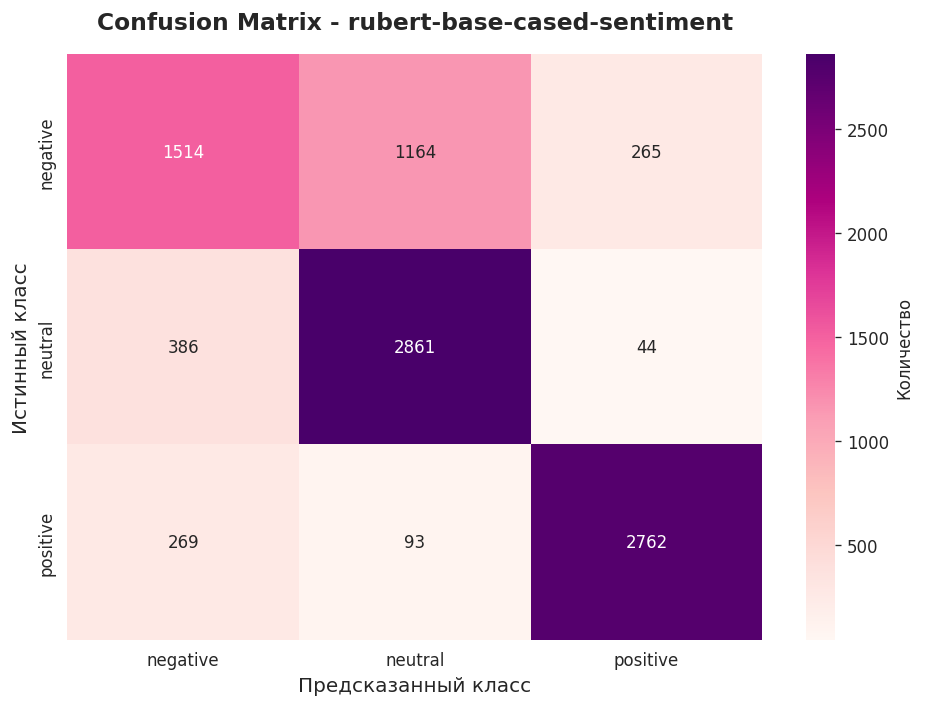

In [ ]:
# Строим confusion matrix
cm_rubert = confusion_matrix(y_test, y_pred_transformer_mapped)

plt.figure(figsize=(8, 6), dpi=120)
sns.heatmap(cm_rubert, annot=True, fmt='d', cmap='RdPu',
            xticklabels=['negative', 'neutral', 'positive'],
            yticklabels=['negative', 'neutral', 'positive'],
            cbar_kws={'label': 'Количество'})

plt.xlabel('Предсказанный класс', fontsize=12, fontweight='medium')
plt.ylabel('Истинный класс', fontsize=12, fontweight='medium')
plt.title(f'Confusion Matrix - rubert-base-cased-sentiment', fontsize=14, fontweight='bold', pad=15)
plt.tight_layout()
plt.show()

#### Анализ матрицы ошибок

| Истинный класс | Предсказанный класс | Основная проблема |
|----------------|---------------------|--------------------|
| **neutral**    | negative (1164)     | Модель **путает нейтральные с негативными** — главная слабость |
| **negative**   | neutral (1164)      | Высокий recall для negative достигается за счет ложных срабатываний |
| **positive**   | negative (269)      | Незначительные ошибки, но требуют внимания |

---

#### Ключевые выводы
1. **Модель склонна к бинарной классификации**  
   Нейтральные тексты систематически смещаются в сторону "negative", что указывает на:
   - Недостаток нейтральных примеров в обучающих данных
   - Сложность дифференциации "neutral" и "negative" в русском языке

2. **Сильная сторона**  
   Высокая точность для позитивных текстов (89%) — модель уверенно определяет явно положительные отзывы.

3. **Критическая проблема**  
   **38.7% всех нейтральных текстов** (1164 из 2943) ошибочно классифицированы как негативные. Это может привести к:
   - Завышенной оценке негативной тональности в реальных данных
   - Некорректному анализу отзывов, где нейтральные мнения важны (например, технические обзоры)

4. **Дисбаланс классов**  
   Несмотря на примерно равное количество примеров в каждом классе (2943/3291/3124), модель явно хуже обучена на "neutral".

> **Итог**: Модель пригодна для задач, где критичен поиск негативных/позитивных отзывов (F1 > 0.77), но **непригодна для анализа нейтральных текстов** без доработки. Требуется дополнительная оптимизация для сбалансированной работы со всеми тремя классами.

## Важные итоги

Анализ тональности — задача с подводными камнями. Наши эксперименты показали, что даже на сбалансированном датасете реальное качество моделей редко превышает 0.75. Это не проблема алгоритмов, а особенность самой задачи: люди часто пишут неоднозначные отзывы, а метки в данных могут быть неточными.

Важный вывод: **бинарная классификация (positive/negative) обычно показывает лучшие результаты**, чем трехклассовая. Нейтральные отзывы систематически путаются с негативными — это видно из матриц ошибок всех моделей. Если в вашей задаче критично различать именно три класса, стоит пересмотреть разметку данных.

**Классические алгоритмы (Logistic Regression, SVM) показали себя с лучшей стороны:**
- Достигли F1-score около 0.73-0.74
- Обучаются быстро и стабильно
- Легко интерпретируются через веса признаков
- Не требуют GPU для обучения

**Трансформеры (RuBERT) дали прирост качества до 0.75 без дообучения на наших данных, но ценой:**
- Высоких вычислительных затрат
- Сложной интерпретации ошибок
- Проблем с классом "neutral"

**Стратегия работы с такими задачами:**
1. Начинайте с классических моделей + TF-IDF
2. Обязательно подбирайте гиперпараметры — в нашем случае это дало небольшое улучшение F1-score, но для вас может оказаться критичным и привести к ОЧЕНЬ хорошим результатам
3. Анализируйте матрицу ошибок, а не только общие метрики. Обязательно смотрите на данные, в них весь смысл!
4. Только после того, как попробовали классический подход переходите к нейросетям

Подбор гиперпараметров — не опция, а необходимость. Даже простая логистическая регрессия без настройки `C`, `class_weight` и солвера показывает на 2-3% худший результат.

**В анализе тональности данные важнее алгоритмов**. Если в исходных данных много субъективных или неоднозначных отзывов, никакая модель не достигнет 0.9 F1-score. Честная оценка качества (0.7-0.75 для трехклассовой задачи) и понимание слабых мест системы важнее погони за идеальными цифрами.